In [1]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import random as rnd
%matplotlib inline

In [2]:
# needs editing for number of colors
def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : a ridiculogram plot of G
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc','#fcba03','#f4fc03', '#5afc03','#03fc88',
              '#03fceb', '#0398fc', '#0356fc', '#3103fc', '#a103fc', '#fc03f4', '#fc036f', '#fc0314', '#fcc603', '#fc6203',
              '#03fca1', '#03b5fc', '#a103fc', '#fca503', '#adfc03', '#fc036f', '#fc7b03', '#ffffff', '#000000'] # map node labels to colors (for the visualization)

    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])-1])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 50
        flabel = False
        
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

reading the network file : virus_virus_network.txt
reading the metadata file : metadata_numbered_final.txt


 spring layout


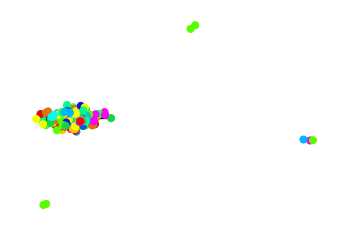

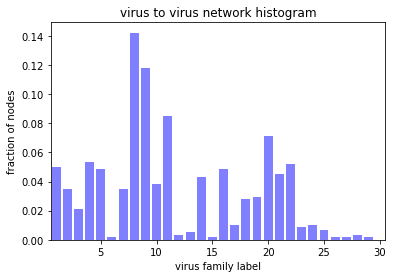

number of nodes, n  = 577
number of edges, m  = 42475
mean degree,    <k> = 147.23
clustering coefficient, C     =  0.87
mean geodesic distance, <ell> =  1.86


In [3]:
fname1 = 'virus_virus_network.txt'
fname2 = 'metadata_numbered_final.txt'

print(f'reading the network file : {fname1}')
G = nx.read_edgelist('./' + fname1, delimiter=',', nodetype=int)
print(f'reading the metadata file : {fname2}\n')
f = open('./' + fname2, 'r')
labels = []
for line in f:
    labels.append(int(line.rstrip('\n')))
f.close()

z = {}
for i in range(0, len(labels)):
    if(i+1 in G.nodes()):
        z[i+1] = labels[i]

#print(z)
def compute_MGD(G):
    # input : a networkx graph G
    # output: the mean geodesic path length (defined in Lecture 2)
    
    # YOUR CODE HERE
    shortest_path = dict(nx.all_pairs_shortest_path_length(G))
    valid_paths = []
    #moving accross the dictionary of shortest paths and removing all 0's and infinities/storing in a list to compute final value
    for key in shortest_path:
        for nested_key in shortest_path[key]:
            tempDict = shortest_path[key]
            #checking all the path lengths to make sure it is not 0 or infinity
            if(tempDict[nested_key] != 0 and tempDict[nested_key] != np.inf):
                #if it is not, add to the valid_paths list
                valid_paths.append(tempDict[nested_key])
    #print(shortest_path)
    #print(valid_paths)
    l_ij_sum = sum(valid_paths)
    #print(l_ij_sum)
    Z = len(valid_paths)
    #print(Z)
    ellm = l_ij_sum/Z
    return ellm
        
n = G.order()
m = G.size()

kmean = 2*m/n
C = nx.transitivity(G)
ellmean = compute_MGD(G)

print(f'\n spring layout')
drawGz(G, z)

counts, bins = np.histogram(list(z.values()), bins = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30], density=True)
plt.bar(bins[:-1], counts, facecolor='b', alpha=.5)
plt.xlabel('virus family label')
plt.ylabel('fraction of nodes')
plt.title('virus to virus network histogram')
plt.xlim(.5, 30.5)
plt.show()

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)
print(f'clustering coefficient, C     = %5.2f' % C)
print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)

In [4]:
def predictLabel_baseline(x):
    # input:  x, dict of observed labels
    # output: baseline predictor, Uniform(\vec{x}-\emptyset)
    
    # YOUR CODE HERE
    xobs = list(x.values())
    xval = [lab for lab in xobs if lab > 0]
    xpred = xval[int(rnd.random()*len(xval))]
    
    return xpred

In [9]:
def predictLabel_global(G, i, x, flag):
    xnu = []
    #xpred = 0.0
    for j in G.nodes():
        if(x[j] > 0):
            xnu.append(x[j])
            
    if(len(xnu) == 0):
        xpred = predictLabel_baseline(x)
        if(flag == 1):
            print(f'node {i} : {x[i]} -> {xpred} (baseline)')
    else:
        xpred = max(set(xnu), key = xnu.count)
        if(flag == 1):
            print(f'node {i} : {x[i]} -> {xpred} (smoothing)')
    return xpred

In [10]:
def compute_ACC_onG(G, x, alpha):
    xo = {}
    for i in G.nodes():
        if(rnd.random() < alpha):
            xo[i] = x[i]
        else:
            xo[i] = -1
    
    xp = {}
    for i in G.nodes():
        if(xo[i] < 0):
            xp[i] = predictLabel_global(G, i, xo, 0)
        else:
            xp[i] = xo[i]
            
    c = len(np.unique(list(x.values())))
    cmat = np.zeros([c,c])
    
    for i in G.nodes():
        if(xo[i] < 0):
            p = xp[i]
            q = x[i]
            cmat[p-1, q-1]+= 1
    
    ACC = np.trace(cmat)/np.sum(cmat)
    
    return ACC  

In [13]:
nreps = 200
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]

ACCm = np.empty([len(alphas), 2])

for b,a in enumerate(alphas):
    alpha = a
    Accs = []
    
    for index in range(nreps):
        ACC = compute_ACC_onG(G, z, alpha)
        Accs.append(ACC)
        
    ACCm[b, 0] = alpha
    ACCm[b, 1] = np.mean(Accs)
    print(f'finished alpha={a} | reps={nreps} | <ACC>= %6.3f' % ACCm[b,1])

KeyboardInterrupt: 

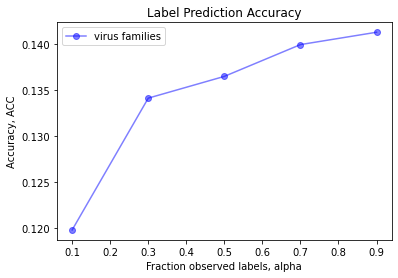

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.plot(ACCm[:,0], ACCm[:,1], 'bo-', alpha=0.5, label='virus families')

plt.title('Label Prediction Accuracy')
plt.ylabel('Accuracy, ACC')
plt.xlabel('Fraction observed labels, alpha')
plt.legend(loc='upper left')
plt.show()